In [2]:
import pandas as pd
import numpy as np
import models_and_functions as MyModels
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torchdiffeq import odeint
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
df_antibiotics, antibiotic_types, df_relative_abundances= MyModels.wrangle_data()
df_relative_abundances = df_relative_abundances.drop_duplicates(subset = ['PatientID', 'DayRelativeToNearestHCT'])
node_model = torch.load('node_model.pth', weights_only=False)
test_df = pd.read_csv('node_model_test_df.csv', index_col = 0)

enterococcus_infections = ['Enterococcus_Faecium',
                           'Enterococcus_Faecium_Vancomycin_Resistant',
                           'Enterococcus_Vancomycin_Resistant',
                           'Enterococcus_Faecalis']

gammmaproteobacteria_infections = ['Escherichia',
                                  'Pseudomonas',
                                  'Klebsiella',
                                  'Klebsiella_Pneumoniae',
                                  'Enterobacter',
                                  'Stenotrophomonas_Maltophilia',
                                  'Citrobacter']


df_infections = pd.read_csv('tblInfectionsCidPapers.csv')
df_bacilli_infections = df_infections[df_infections['InfectiousAgent'].isin(enterococcus_infections)]
df_gammaproteobacteria_infections = df_infections[df_infections['InfectiousAgent'].isin(gammmaproteobacteria_infections)]
glv_model = torch.load('glv_model.pth', weights_only = False)
glv_test_df = pd.read_csv('glv_model_test_df.csv', index_col = False)
glv_test_df_relative_abundances = test_df[test_df['SampleID'].isin(glv_test_df['SampleID'].unique())]
node_model_trained_on_glv_data_test_df = pd.read_csv('node_model_trained_on_glv_data_test_df.csv', index_col = 0)
node_model_trained_on_glv_data = torch.load('node_model_trained_on_glv_data.pth', weights_only=False)
print(np.all(glv_test_df_relative_abundances.to_numpy() == node_model_trained_on_glv_data_test_df.to_numpy()))


CUDA is available. Using GPU.
GPU Device name: NVIDIA A40
GPU Memory Allocated: 0.0 GB
GPU Memory Cached: 0.0 GB


/data1/xavierj/isaac/Neural_ODEs_Paper_Code_2/Clinical_Data_Experiments/models_and_functions.py:31: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print(f"GPU Memory Cached: {round(torch.cuda.memory_cached(0)/1024**3,1)} GB")


# Predicting Intestinal Dominations by Bacilli and Gammaproteobacteria:

We compare, for all samples in the test set, whether a domination event occurred (binary outcome), with the max(node predicted trajectory). We use the max(node predicted trajectory) as the score, and plot an receiver operating characteristic (ROC) curve, reporting area under the curve (AUC) as a performance metric for predicting domination events.

computing domination predictions...
plotting ROC curve...


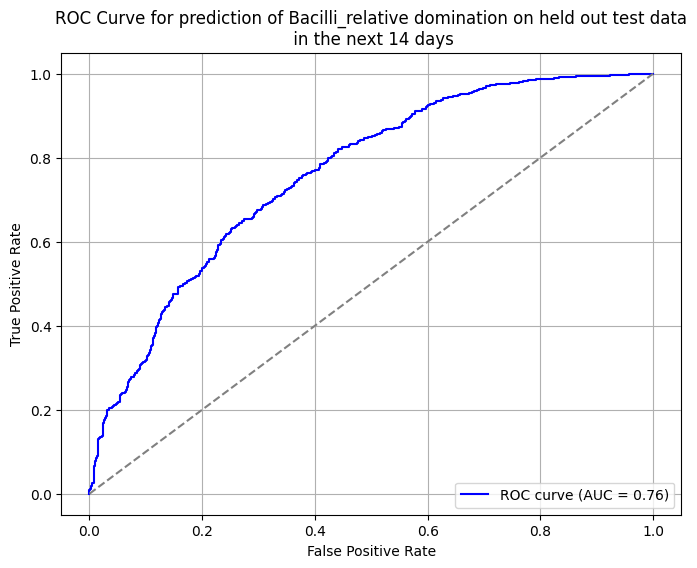

computing domination predictions...
plotting ROC curve...


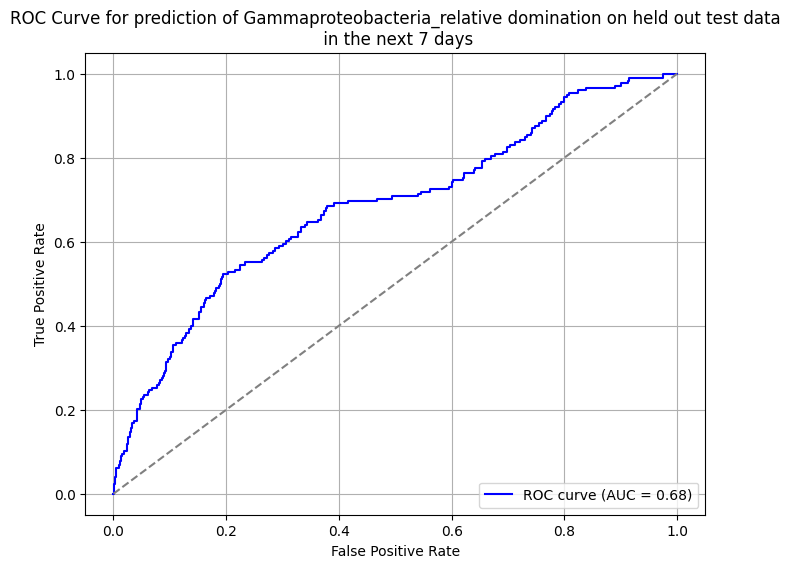

0.68397335512649

In [2]:
# Bacilli
MyModels.make_domination_predictions(node_model, test_df, index_of_taxa=2, prediction_size = 7)
# Gammaproteobacteria 
MyModels.make_domination_predictions(node_model, test_df, index_of_taxa=9)

computing domination predictions...
plotting ROC curve...


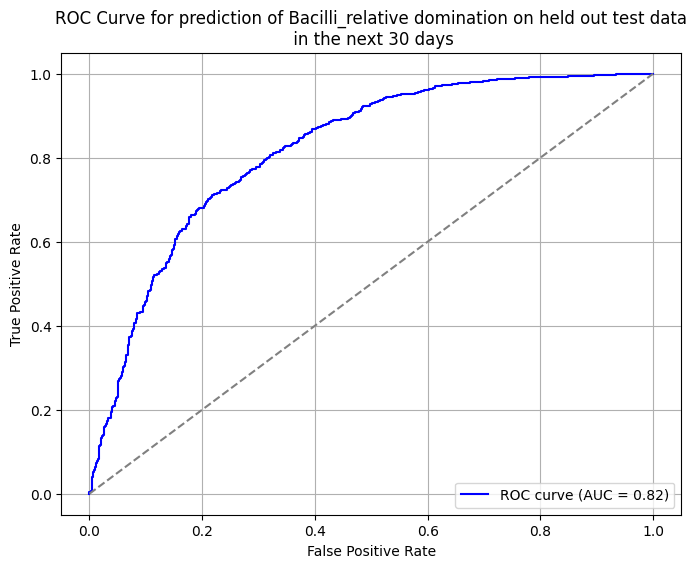

computing domination predictions...
plotting ROC curve...


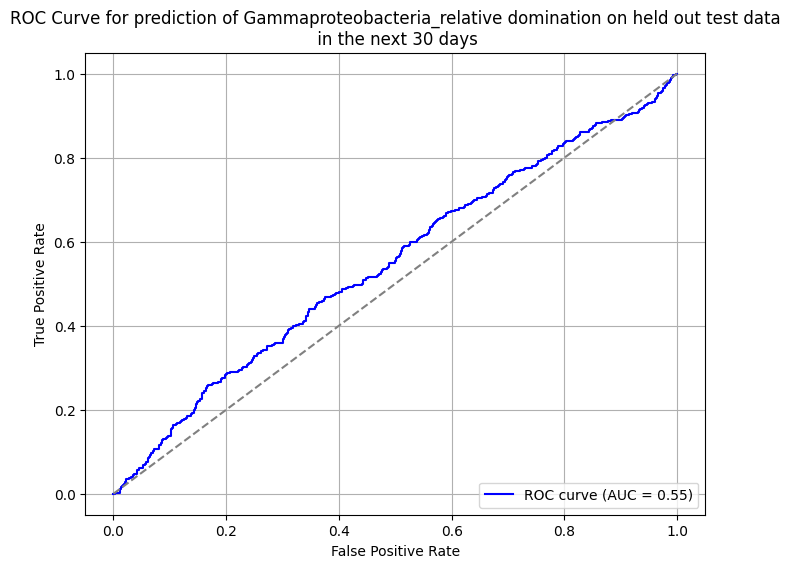

0.5468815454888124

In [3]:
MyModels.make_domination_predictions(node_model, test_df, index_of_taxa=2, prediction_size = 30)
# Gammaproteobacteria 
MyModels.make_domination_predictions(node_model, test_df, index_of_taxa=9, prediction_size = 30)

# Predicting Bloodstream Infections by Enterococcus based on Model Dynamical Predictions

In this section we abuse the NODE dynamical model to predict bloodstream infections. The model was not trained to do this task. 

In [70]:
import matplotlib.pyplot as plt
import numpy as np

def plot_abundance_distribution_histogram(
    abundance_predictions, prediction_type, name_of_class, 
    range_of_infection_prediction, name, bins=20, save_eps = False
):
    """
    Create a histogram comparing score distributions for infected vs uninfected groups,
    with separate y-axis scales and side-by-side bars to account for class imbalance.
    """
    # Select score column based on prediction type
    if prediction_type == 'model':
        scores = abundance_predictions[:, 0]
        x_label = 'Mean of Predicted Abundance Trajectory of Bacilli'
        title_desc = f'based on {name} predictions'
    elif prediction_type == 'initial':
        scores = abundance_predictions[:, 2]
        x_label = 'Initial Abundance Level'
        title_desc = 'based on initial abundance measurement'
    else:
        raise ValueError("prediction_type must be 'model' or 'initial'")

    y_true = abundance_predictions[:, 1]
    infected_scores = scores[y_true == 1]
    uninfected_scores = scores[y_true == 0]

    # Create figure and twin y-axis
    fig, ax1 = plt.subplots(figsize=(8.4, 5))
    ax2 = ax1.twinx()

    # Compute shared bins so both histograms align
    all_scores = np.concatenate([infected_scores, uninfected_scores])
    bins = np.histogram_bin_edges(all_scores, bins=bins)

    # Compute bin centers and width for side-by-side plotting
    bin_width = np.diff(bins)
    bin_centers = bins[:-1] + bin_width / 2
    offset = bin_width / 4  # controls spacing between bars

    # Compute histograms (counts) manually so we can offset them
    n_uninf, _ = np.histogram(uninfected_scores, bins=bins)
    n_inf, _ = np.histogram(infected_scores, bins=bins)

    # Plot side-by-side bars
    ax1.bar(bin_centers - offset, n_uninf, width=bin_width/2,
            color='#3498db', edgecolor='black',
            linewidth=0.5, label=f'Uninfected (n={len(uninfected_scores)})')

    ax2.bar(bin_centers + offset, n_inf, width=bin_width/2,
            color='#e74c3c', edgecolor='black',
            linewidth=0.5, label=f'Infected (n={len(infected_scores)})')

    # Labels and titles
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('Count (Uninfected)', color='#3498db')
    ax2.set_ylabel('Count (Infected)', color='#e74c3c')

    plt.title(
        f'Distribution of {x_label} for {name_of_class} Infections\n'
        f'({range_of_infection_prediction} days in advance, {title_desc})'
    )

    # Legends
    leg1 = ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0))
    leg2 = ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
    for leg in [leg1, leg2]:
        ax1.figure.add_artist(leg) 

    # Styling
    ax1.grid(axis='y')
    fig.tight_layout()
    if save_eps:
        plt.savefig(f'./eps_figures/infection_prediction_historgram_{range_of_infection_prediction}_days_in_advance_{title_desc.replace(" ", "_")}.eps', format="eps", bbox_inches='tight')
    plt.show()



def plot_roc_and_compute_auc(abundance_predictions, prediction_type, name_of_class, 
                              range_of_infection_prediction, name, plot_roc_curve=True,save_eps = False):
    if prediction_type == 'model':
        y_scores = abundance_predictions[:, 0]
        title_desc = f'based on {name} predictions' if 'GROUND_TRUTH' in name else f'based on {name} predictions'
    elif prediction_type == 'initial':
        y_scores = abundance_predictions[:, 2]
        title_desc = 'based on initial abundance measurement'
    else:
        raise ValueError("prediction_type must be 'model' or 'initial'")
    
    y_true = abundance_predictions[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    if plot_roc_curve:
        plt.figure(figsize=(8, 6), num=None)
        plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
        if 'GROUND_TRUTH' in name and prediction_type == 'model':
            title_desc = f'based on {name} measurements'
        
        plt.title(f'ROC Curve for prediction of {name_of_class} infections '
                  f'{range_of_infection_prediction} days in advance {title_desc}')
        plt.legend(loc='lower right')
        plt.grid()
        if save_eps:
            plt.savefig(f'./eps_figures/infection_prediction_ROC_curve_{range_of_infection_prediction}_days_in_advance_{name.replace(" ", "_")}.eps', format="eps", bbox_inches='tight')
        plt.show()
    
    return roc_auc


def make_infection_predictions(model, test_df, index_of_taxa=2, range_of_node_prediction=7, 
                               range_of_infection_prediction=7, number_of_taxa='reduced', 
                               method='euler', aggregate_statistic='mean', 
                               convert_to_relative_abundances=False, name='NODE', plot_roc_curve=True, 
                               plot_histogram=False, save_eps = False):
    abundance_predictions = []
    
    if index_of_taxa == 2:
        infections_df = df_bacilli_infections
        name_of_class = 'Bacilli'
    if index_of_taxa == 9:
        infections_df = df_gammaproteobacteria_infections
        name_of_class = 'Gammaproteobacteria'
    
    for patient_id in test_df['PatientID'].unique():
        model.patient_id = patient_id
        t_preds, t_true, y_trues, true_indices = MyModels.get_data(test_df, patient_id, number_of_taxa=number_of_taxa)
        
        for i in range(len(t_true)-1):
            t_start = t_true[i]
            y0 = y_trues[i]
            t_end = t_start + range_of_node_prediction
            t_preds = torch.linspace(t_start, t_end, int((t_end-t_start)*3)).to(device)
            y_pred_trajectory = odeint(model, y0, t_preds, method=method)
            
            if convert_to_relative_abundances:
                y0 = torch.nn.functional.normalize(torch.clamp(y0, min=0), p=1, dim=0)
                y_pred_trajectory = torch.nn.functional.normalize(torch.clamp(y_pred_trajectory, min=0), p=1, dim=1)

            taxa_pred_trajectory = y_pred_trajectory[:, index_of_taxa]
            actual_infection_times = list(infections_df[infections_df['PatientID']==patient_id]['DayRelativeToNearestHCT'])
            t_start = t_start.cpu().numpy()
            actual_infection = int(any((t_start <= t < t_start + range_of_infection_prediction) for t in actual_infection_times))
            initial_bacilli_abundance_level = np.float64(y0[index_of_taxa].cpu().detach().item())
            
            if aggregate_statistic == 'max':
                taxa_pred_summary_abundance_level = np.float64(torch.max(taxa_pred_trajectory).item())
            if aggregate_statistic == 'mean':
                taxa_pred_summary_abundance_level = np.float64(torch.mean(taxa_pred_trajectory).item())
            
            abundance_predictions.append([taxa_pred_summary_abundance_level, actual_infection, initial_bacilli_abundance_level])
            
    abundance_predictions = np.array(abundance_predictions)
    abundance_predictions = abundance_predictions[~np.isnan(abundance_predictions).any(axis=1)]

    # Plot histogram for model predictions
    if plot_histogram:
        print('plotting histogram for model predictions...')
        plot_abundance_distribution_histogram(abundance_predictions, 'model', name_of_class, 
                                           range_of_infection_prediction, name, save_eps = save_eps)
        print('plotting histogram for initial abundances...')
        plot_abundance_distribution_histogram(abundance_predictions, 'initial', name_of_class, 
                                           range_of_infection_prediction, name, save_eps = save_eps)
    
    # Compute auc and plot ROC curve for model predictions
    model_auc = plot_roc_and_compute_auc(abundance_predictions, 'model', name_of_class, 
                                          range_of_infection_prediction, name, plot_roc_curve=plot_roc_curve, save_eps = save_eps)

    # Compute auc and plot ROC curve for initial abundances
    initial_abundance_auc = plot_roc_and_compute_auc(abundance_predictions, 'initial', name_of_class, 
                                                       range_of_infection_prediction, name, plot_roc_curve=plot_roc_curve, save_eps = save_eps)
    
    return model_auc, initial_abundance_auc


def make_infection_predictions_ground_truth(test_df, index_of_taxa=2, range_of_node_prediction=7, 
                               range_of_infection_prediction=7, number_of_taxa='reduced', 
                               method='euler', aggregate_statistic='mean', 
                               convert_to_relative_abundances=False, name='ground truth', plot_roc_curve=True, 
                               plot_histogram=False, save_eps = False):
    abundance_predictions = []
    
    if index_of_taxa == 2:
        infections_df = df_bacilli_infections
        name_of_class = 'Bacilli'
    if index_of_taxa == 9:
        infections_df = df_gammaproteobacteria_infections
        name_of_class = 'Gammaproteobacteria'
    
    for patient_id in test_df['PatientID'].unique():
        t_preds, t_true, y_trues, true_indices = MyModels.get_data(test_df, patient_id, number_of_taxa=number_of_taxa)
        patient_data = test_df[test_df['PatientID'] == patient_id].copy()
        
        for i in range(len(t_true)-1):
            t_start = t_true[i]
            y0 = y_trues[i]
            t_end = t_start + range_of_node_prediction
            
            t_start_np = t_start.cpu().numpy()
            t_end_np = t_end.cpu().numpy() if hasattr(t_end, 'cpu') else t_end
            
            window_mask = (patient_data['DayRelativeToNearestHCT'] > t_start_np) & \
                         (patient_data['DayRelativeToNearestHCT'] <= t_end_np)
            window_data = patient_data[window_mask]
            
            if len(window_data) == 0:
                continue
                
            taxa_column = test_df.columns[index_of_taxa]
            taxa_measurements = window_data[taxa_column].values
            
            if convert_to_relative_abundances:
                taxa_cols = [col for col in test_df.columns if col not in ['PatientID', 'DayRelativeToNearestHCT']]
                window_taxa_data = window_data[taxa_cols].values
                row_sums = np.sum(window_taxa_data, axis=1)
                normalized_data = window_taxa_data / row_sums[:, np.newaxis]
                taxa_measurements = normalized_data[:, index_of_taxa]
            
            taxa_measurements = taxa_measurements[~np.isnan(taxa_measurements)]
            
            if len(taxa_measurements) == 0:
                continue
                
            if aggregate_statistic == 'max':
                taxa_pred_summary_abundance_level = np.max(taxa_measurements)
            elif aggregate_statistic == 'mean':
                taxa_pred_summary_abundance_level = np.mean(taxa_measurements)
            
            actual_infection_times = list(infections_df[infections_df['PatientID']==patient_id]['DayRelativeToNearestHCT'])
            actual_infection = int(any((t_start_np <= t < t_start_np + range_of_infection_prediction) for t in actual_infection_times))
            initial_bacilli_abundance_level = np.float64(y0[index_of_taxa].cpu().detach().item())
            
            abundance_predictions.append([taxa_pred_summary_abundance_level, actual_infection, initial_bacilli_abundance_level])
            
    abundance_predictions = np.array(abundance_predictions)
    abundance_predictions = abundance_predictions[~np.isnan(abundance_predictions).any(axis=1)]

    # Plot histogram for model predictions
    if plot_histogram:
        print('plotting histogram for model predictions...')
        plot_abundance_distribution_histogram(abundance_predictions, 'model', name_of_class, 
                                           range_of_infection_prediction, name, save_eps = save_eps)
        print('plotting histogram for initial abundances...')
        plot_abundance_distribution_histogram(abundance_predictions, 'initial', name_of_class, 
                                           range_of_infection_prediction, name, save_eps = save_eps)
    
    # Compute auc and plot ROC curve for model predictions
    model_auc = plot_roc_and_compute_auc(abundance_predictions, 'model', name_of_class, 
                                          range_of_infection_prediction, name, plot_roc_curve=plot_roc_curve, save_eps = save_eps)

    # Compute auc and plot ROC curve for initial abundances
    initial_abundance_auc = plot_roc_and_compute_auc(abundance_predictions, 'initial', name_of_class, 
                                                       range_of_infection_prediction, name, plot_roc_curve=plot_roc_curve, save_eps = save_eps)

    return model_auc, initial_abundance_auc


def make_infection_predictions_ground_truth_weighted_average(test_df, index_of_taxa=2, 
                               range_of_node_prediction=7, range_of_infection_prediction=7, 
                               number_of_taxa='reduced', method='euler', aggregate_statistic='mean', 
                               convert_to_relative_abundances=False, name='ground truth interpolation', plot_roc_curve=True, 
                               plot_histogram=False, save_eps = False):
    abundance_predictions = []
    
    if index_of_taxa == 2:
        infections_df = df_bacilli_infections
        name_of_class = 'Bacilli'
    if index_of_taxa == 9:
        infections_df = df_gammaproteobacteria_infections
        name_of_class = 'Gammaproteobacteria'
    
    for patient_id in test_df['PatientID'].unique():
        t_preds, t_true, y_trues, true_indices = MyModels.get_data(test_df, patient_id, number_of_taxa=number_of_taxa)
        patient_data = test_df[test_df['PatientID'] == patient_id].copy()
        
        for i in range(len(t_true)-1):
            t_start = t_true[i]
            y0 = y_trues[i]
            t_end = t_start + range_of_node_prediction
            
            t_start_np = t_start.cpu().numpy()
            t_end_np = t_end.cpu().numpy() if hasattr(t_end, 'cpu') else t_end
            
            window_mask = (patient_data['DayRelativeToNearestHCT'] > t_start_np) & \
                         (patient_data['DayRelativeToNearestHCT'] <= t_end_np)
            window_data = patient_data[window_mask].sort_values('DayRelativeToNearestHCT')
            
            if len(window_data) == 0:
                continue
                
            taxa_column = test_df.columns[index_of_taxa]
            taxa_measurements = window_data[taxa_column].values
            measurement_times = window_data['DayRelativeToNearestHCT'].values
            
            if convert_to_relative_abundances:
                taxa_cols = [col for col in test_df.columns if col not in ['PatientID', 'DayRelativeToNearestHCT']]
                window_taxa_data = window_data[taxa_cols].values
                row_sums = np.sum(window_taxa_data, axis=1)
                normalized_data = window_taxa_data / row_sums[:, np.newaxis]
                taxa_measurements = normalized_data[:, index_of_taxa]
            
            valid_mask = ~np.isnan(taxa_measurements)
            taxa_measurements = taxa_measurements[valid_mask]
            measurement_times = measurement_times[valid_mask]
            
            if len(taxa_measurements) == 0:
                continue
            
            if aggregate_statistic == 'max':
                taxa_pred_summary_abundance_level = np.max(taxa_measurements)
            elif aggregate_statistic == 'mean':
                if len(taxa_measurements) == 1:
                    taxa_pred_summary_abundance_level = taxa_measurements[0]
                else:
                    weights = np.zeros(len(taxa_measurements))
                    
                    weights[0] = (measurement_times[0] - t_start_np) + \
                                 (measurement_times[1] - measurement_times[0]) / 2
                    
                    for j in range(1, len(taxa_measurements) - 1):
                        weights[j] = (measurement_times[j] - measurement_times[j-1]) / 2 + \
                                    (measurement_times[j+1] - measurement_times[j]) / 2
                    
                    weights[-1] = (measurement_times[-1] - measurement_times[-2]) / 2 + \
                                  (t_end_np - measurement_times[-1])
                    
                    taxa_pred_summary_abundance_level = np.average(taxa_measurements, weights=weights)
            
            actual_infection_times = list(infections_df[infections_df['PatientID']==patient_id]['DayRelativeToNearestHCT'])
            actual_infection = int(any((t_start_np <= t < t_start_np + range_of_infection_prediction) for t in actual_infection_times))
            initial_bacilli_abundance_level = np.float64(y0[index_of_taxa].cpu().detach().item())
            
            abundance_predictions.append([taxa_pred_summary_abundance_level, actual_infection, initial_bacilli_abundance_level])
            
    abundance_predictions = np.array(abundance_predictions)
    abundance_predictions = abundance_predictions[~np.isnan(abundance_predictions).any(axis=1)]

    # Plot histogram for model predictions
    if plot_histogram:
        print('plotting histogram for model predictions...')
        plot_abundance_distribution_histogram(abundance_predictions, 'model', name_of_class, 
                                           range_of_infection_prediction, name, save_eps = save_eps)
        print('plotting histogram for initial abundances...')
        plot_abundance_distribution_histogram(abundance_predictions, 'initial', name_of_class, 
                                           range_of_infection_prediction, name, save_eps = save_eps)
    
    # Compute auc and plot ROC curve for model predictions
    model_auc = plot_roc_and_compute_auc(abundance_predictions, 'model', name_of_class, 
                                          range_of_infection_prediction, name, plot_roc_curve=plot_roc_curve, save_eps = save_eps)

    # Compute auc and plot ROC curve for initial abundances
    initial_abundance_auc = plot_roc_and_compute_auc(abundance_predictions, 'initial', name_of_class, 
                                                       range_of_infection_prediction, name, plot_roc_curve=plot_roc_curve, save_eps = save_eps)

    return model_auc, initial_abundance_auc


# Example usage with histograms enabled:
# model_auc, initial_auc = make_infection_predictions_ground_truth_weighted_average(
#     test_df, index_of_taxa=2, range_of_node_prediction=7, 
#     range_of_infection_prediction=7, plot_roc_curve=False, plot_histogram=False
# )

# make_infection_predictions(node_model, glv_test_df_relative_abundances,  plot_roc_curve=True, plot_histogram=True)

In [ ]:
make_infection_predictions(node_model, test_df,range_of_node_prediction=7, 
                               range_of_infection_prediction=7,  plot_roc_curve=True, plot_histogram=True,
                          save_eps = True)

make_infection_predictions(node_model, test_df,range_of_node_prediction=100, 
                               range_of_infection_prediction=100,  plot_roc_curve=True, plot_histogram=True,
                          save_eps = True)

# make_infection_predictions_ground_truth_weighted_average(
#     test_df, index_of_taxa=2, range_of_node_prediction=7, 
#     range_of_infection_prediction=7, plot_roc_curve=False, plot_histogram=True
# )

# make_infection_predictions_ground_truth(
#     test_df, index_of_taxa=2, range_of_node_prediction=7, 
#     range_of_infection_prediction=7, plot_roc_curve=False, plot_histogram=False
# )

In [ ]:
node_aucs = []
glv_aucs = []
ground_truth_mean_aucs = []
ground_truth_max_aucs = []
ground_truth_weighted_avg_aucs = []
constant_aucs = []

for days in list(range(1, 30, 3)) + list(range(30, 60, 4)) + list(range(62, 100, 6)):
    node_auc, constant_auc = make_infection_predictions(node_model, glv_test_df_relative_abundances, range_of_node_prediction = days, range_of_infection_prediction = days, plot_roc_curve=False, plot_histogram=False)
    glv_auc, _ = make_infection_predictions(glv_model, glv_test_df, range_of_node_prediction = days, range_of_infection_prediction = days,convert_to_relative_abundances=True, name="GLV", plot_roc_curve=False, plot_histogram=False)
    ground_truth_mean_auc, _ = make_infection_predictions_ground_truth(glv_test_df_relative_abundances, range_of_node_prediction = days, aggregate_statistic = 'mean', range_of_infection_prediction = days, plot_roc_curve=False, plot_histogram=False)
    ground_truth_max_auc, _ = make_infection_predictions_ground_truth(glv_test_df_relative_abundances, range_of_node_prediction = days, aggregate_statistic = 'max', range_of_infection_prediction = days,plot_roc_curve=False, plot_histogram=False)
    ground_truth_weighted_avg_auc, _ = make_infection_predictions_ground_truth_weighted_average(glv_test_df_relative_abundances, range_of_node_prediction = days, range_of_infection_prediction = days,plot_roc_curve=False, plot_histogram=False)
    
    ground_truth_mean_aucs.append(ground_truth_mean_auc)
    ground_truth_max_aucs.append(ground_truth_max_auc)
    ground_truth_weighted_avg_aucs.append(ground_truth_weighted_avg_auc)
    node_aucs.append(node_auc)
    glv_aucs.append(glv_auc)
    constant_aucs.append(constant_auc)
    print(days)


1
4
7
10
13
16
19
22
25
28
30
34
38
42
46


In [ ]:

times = list(range(1, 30, 3)) + list(range(30, 60, 4)) + list(range(62, 100, 6))
plt.plot(times, node_aucs, label = 'NODE Prediction based AUCs')
plt.plot(times, glv_aucs, label = 'GLV Prediction based AUCs')
plt.plot(times, constant_aucs, label = 'Initial Abundance Prediction based AUCs')
plt.plot(times[1:], ground_truth_mean_aucs[1:], label = 'Mean of ground truth measurements predicted AUCs')
plt.plot(times[1:], ground_truth_max_aucs[1:], label = 'Max of ground truth measurements predicted AUCs')
plt.plot(times[1:], ground_truth_weighted_avg_aucs[1:], label = 'Constant interpolated Ground truth based AUCs')
plt.scatter(times, node_aucs)
plt.scatter(times, glv_aucs)
plt.scatter(times, constant_aucs)
plt.scatter(times[1:], ground_truth_mean_aucs[1:])
plt.scatter(times[1:], ground_truth_max_aucs[1:])
plt.scatter(times[1:], ground_truth_weighted_avg_aucs[1:])
plt.xlabel('Number of Days in Advance Prediction')
plt.ylabel('Test AUC For Infection Prediction')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.title('Enterococcus Infection Prediction Based on Mean of Model Relative Abundance Predictions' )
plt.savefig(
    "bloodstream_infection_prediction_aucs.eps",
    format="eps",
    bbox_inches="tight",
    pad_inches=0.1   # adjust padding if you need more/less whitespace
)



